In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
n_r_states = 8

def get_possible_actions(state):
    actions = {
        0: [0, 1],                        # starting state A (0 = left, 1 = right)
        1: np.arange(2, n_r_states+2, 1), # middle state B
        2: []                             # terminal state
    }
    return actions[state]

def get_Qmask(state):
    mask = np.zeros((1, n_r_states+2), dtype=bool)
    if state == 0:
        mask[0, 2:] = True   # if in starting state A, mask everything but left (0) and right (1)
    elif state == 1:
        mask[0, 0:2] = True  # if in middle state B, mask left (0) and right (1), leave remaining
    elif state == 2:
        mask[0, :] = True    # if in terminal state, mask all
        
    return mask

def get_next_state(state, action):
    transitions = {
        0: {0: 1, 1: 2},                                 # if in starting state A and left (0), now in middle state B, otherwise right (1) is terminal
        1: {x: 2 for x in np.arange(0, n_r_states+2, 1)} # all actions in middle state B lead to terminal state
    }
    return transitions[state][action]

def get_reward(state, action, mu_reward):
    rewards = {
        0: 0,                                         # if in starting state A, all rewards are 0
        1: np.random.normal(loc=mu_reward, scale=1.0) # if in middle state B, reward is drawn from normal distribution with variance 1 and mean = mu_reward
    }
    return rewards[state]

In [7]:
def do_training_qlearn(num_training_rounds=300, epsilon=0.1, mu_reward=-0.1, gamma=1):
    Q_table = np.zeros((3, n_r_states + 2))
    num_visits = np.zeros((3, n_r_states + 2))
    alpha_table = np.ones((3, n_r_states + 2))
    left_right = np.zeros((num_training_rounds, 2))
    for i in range(num_training_rounds):
        current_state = 0
        done = False
        while not done:
            possible_actions = get_possible_actions(current_state)
            if np.random.rand() <= epsilon:
                action = np.random.choice(possible_actions)
            else:
                action_Q_values = np.ma.MaskedArray(Q_table[current_state, :], get_Qmask(current_state))
                action = np.random.choice(np.where(action_Q_values == action_Q_values.max())[0])
                
            if current_state == 0:
                left_right[i][action] += 1

            reward = get_reward(current_state, action, mu_reward)
            next_state = get_next_state(current_state, action)
            num_visits[current_state, action] += 1
            alpha_table[current_state, action] = 1/(num_visits[current_state, action])**0.8

            action_next_Q_values = np.ma.MaskedArray(Q_table[next_state, :], get_Qmask(next_state))
            if next_state == 2:
                max_Q = 0
            else:
                max_Q = action_next_Q_values.max()
            Q_table[current_state, action] = Q_table[current_state, action] + alpha_table[current_state, action]*(reward + gamma*max_Q - Q_table[current_state, action])

            if next_state == 2:
                done = True
    
            current_state = next_state
        
    return left_right

In [8]:
def do_training_doubleqlearn(num_training_rounds=300, epsilon=0.1, mu_reward=-0.1, gamma=1):
    QA_table = np.zeros((3, n_r_states + 2))
    QB_table = np.zeros((3, n_r_states + 2))
    num_visits_A = np.zeros((3, n_r_states + 2))
    num_visits_B = np.zeros((3, n_r_states + 2))
    alpha_table_A = np.ones((3, n_r_states + 2))
    alpha_table_B = np.ones((3, n_r_states + 2))
    left_right = np.zeros((num_training_rounds, 2))

    for i in range(num_training_rounds):
        current_state = 0
        done = False
        while not done:
            possible_actions = get_possible_actions(current_state)
            if np.random.rand() <= epsilon:
                action = np.random.choice(possible_actions)
            else:
                action_QA_values = np.ma.MaskedArray(QA_table[current_state, :], get_Qmask(current_state))
                action_QB_values = np.ma.MaskedArray(QB_table[current_state, :], get_Qmask(current_state))
                action_Q_values = (action_QA_values + action_QB_values)/2 # choose action based on average of QA and QB

                action = np.random.choice(np.where(action_Q_values == action_Q_values.max())[0])
                
            if current_state == 0:
                left_right[i][action] += 1

            reward = get_reward(current_state, action, mu_reward)
            next_state = get_next_state(current_state, action)

            if np.random.rand() < 0.5: # randomly update either QA or QB
                action_next_Q_values = np.ma.MaskedArray(QA_table[next_state, :], get_Qmask(next_state))
                if next_state == 2:
                    max_Q = 0
                else:
                    max_Q_action = np.random.choice(np.where(action_next_Q_values == action_next_Q_values.max())[0])
                    max_Q = QB_table[next_state, max_Q_action]
                
                num_visits_A[current_state, action] += 1
                alpha_table_A[current_state, action] = 1/((num_visits_A[current_state, action])**0.8)

                QA_table[current_state, action] = QA_table[current_state, action] + alpha_table_A[current_state, action]*(reward + gamma*max_Q - QA_table[current_state, action])
            else:
                action_next_Q_values = np.ma.MaskedArray(QB_table[next_state, :], get_Qmask(next_state))
                if next_state == 2:
                    max_Q = 0
                else:
                    max_Q_action = np.random.choice(np.where(action_next_Q_values == action_next_Q_values.max())[0])
                    max_Q = QA_table[next_state, max_Q_action]
                    
                num_visits_B[current_state, action] += 1
                alpha_table_B[current_state, action] = 1/((num_visits_B[current_state, action])**0.8)

                QB_table[current_state, action] = QB_table[current_state, action] + alpha_table_B[current_state, action]*(reward + gamma*max_Q - QB_table[current_state, action])

            if next_state == 2:
                done = True

            current_state = next_state
        
    return left_right

In [10]:
lrs = []
for i in range(100):
    left_right = do_training_qlearn(num_training_rounds=300, epsilon=0.1, mu_reward=-0.1, gamma=1)
    lrs.append(left_right)
    
lrs_double = []
for i in range(100):
    left_right = do_training_doubleqlearn(num_training_rounds=300, epsilon=0.1, mu_reward=-0.1, gamma=1)
    lrs_double.append(left_right)

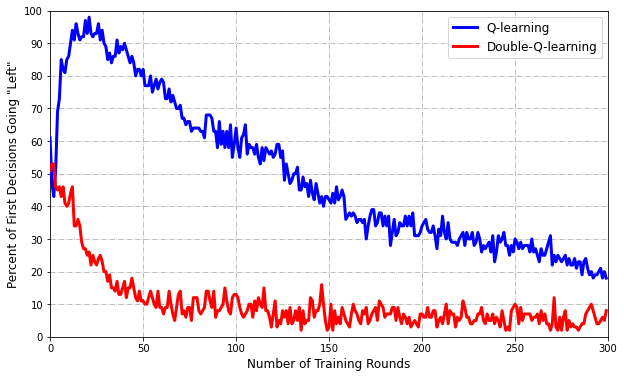

In [12]:
training_runs_q = np.array(lrs)
training_sums_q = training_runs_q.sum(axis=0)
proportion_q = training_sums_q[:, 0]/(training_sums_q[:, 1]+training_sums_q[:, 0])

training_runs_dq = np.array(lrs_double)
training_sums_dq = training_runs_dq.sum(axis=0)
proportion_dq = training_sums_dq[:, 0]/(training_sums_dq[:, 1]+training_sums_dq[:, 0])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
_ = ax.plot(100*proportion_q, c='blue', linewidth=3, zorder=3, label='Q-learning')
_ = ax.plot(100*proportion_dq, c='red', linewidth=3, zorder=4, label='Double-Q-learning')

_ = ax.set_xlim([0, 300])
_ = ax.set_ylim([0, 100])
_ = ax.set_yticks([x for x in np.linspace(0, 100, 11)])
_ = ax.set_xticks([x for x in np.arange(0, 350, 50)])
_ = ax.legend(fontsize=12)
_ = ax.grid(linestyle='-.', zorder=1)
_ = ax.set_xlabel('Number of Training Rounds', fontsize=12)
_ = ax.set_ylabel('Percent of First Decisions Going "Left"', fontsize=12)

In [13]:
lrs = []
for i in range(100):
    left_right = do_training_qlearn(num_training_rounds=300, epsilon=0.1, mu_reward=0.1, gamma=1)
    lrs.append(left_right)
    
lrs_double = []
for i in range(100):
    left_right = do_training_doubleqlearn(num_training_rounds=300, epsilon=0.1, mu_reward=0.1, gamma=1)
    lrs_double.append(left_right)

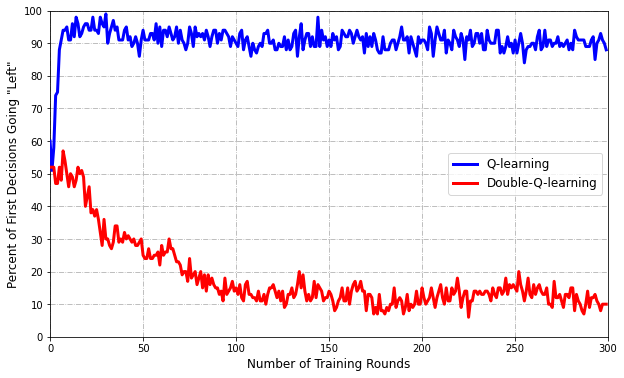

In [14]:
training_runs_q = np.array(lrs)
training_sums_q = training_runs_q.sum(axis=0)
proportion_q = training_sums_q[:, 0]/(training_sums_q[:, 1]+training_sums_q[:, 0])

training_runs_dq = np.array(lrs_double)
training_sums_dq = training_runs_dq.sum(axis=0)
proportion_dq = training_sums_dq[:, 0]/(training_sums_dq[:, 1]+training_sums_dq[:, 0])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
_ = ax.plot(100*proportion_q, c='blue', linewidth=3, zorder=3, label='Q-learning')
_ = ax.plot(100*proportion_dq, c='red', linewidth=3, zorder=4, label='Double-Q-learning')

_ = ax.set_xlim([0, 300])
_ = ax.set_ylim([0, 100])
_ = ax.set_yticks([x for x in np.linspace(0, 100, 11)])
_ = ax.set_xticks([x for x in np.arange(0, 350, 50)])
_ = ax.legend(fontsize=12)
_ = ax.grid(linestyle='-.', zorder=1)
_ = ax.set_xlabel('Number of Training Rounds', fontsize=12)
_ = ax.set_ylabel('Percent of First Decisions Going "Left"', fontsize=12)